In [2]:
# Celda 1: Instalación de dependencias
!pip install faker ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 37.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,

In [4]:
# --- CELDA 1: GENERADOR HÍBRIDO (TIENDAS REALES DENUE + EMPLEADOS SIMULADOS) ---
import sqlite3
import random
import pandas as pd
import numpy as np
from faker import Faker
from datetime import date, timedelta

# --- CONFIGURACIÓN ---
ARCHIVO_CSV = "tiendas2.csv" # <--- ¡Asegúrate de subir este archivo a Colab!
NUM_TIENDAS_OBJETIVO = 300       # Las que seleccionaremos del archivo
NUM_EMPLEADOS_TOTAL = 2500       # Universo completo simulado
USUARIOS_TRANSPORTE = 1065       # Dato real de usuarios

DB_NAME = "oxxo_demo.db"
fake = Faker('es_MX')
Faker.seed(42)
random.seed(42)
np.random.seed(42)

print(f"--- INICIANDO GENERACIÓN CON DATOS REALES (DENUE) ---")

# 1. CARGAR Y PROCESAR TIENDAS REALES
try:
    # Intentamos leer con encoding latino (común en archivos de gobierno/Excel)
    df_real = pd.read_csv(ARCHIVO_CSV, encoding='latin-1')
    df_real = df_real[
    (df_real['Latitud'] < 29) &
    (df_real['Longitud'] > -106.3)
]
except:
    # Si falla, intentamos utf-8
    df_real = pd.read_csv(ARCHIVO_CSV, encoding='utf-8')

print(f"-> Archivo cargado. Total registros originales: {len(df_real)}")

# Seleccionamos las columnas clave (Ajusta nombres si varían ligeramente)
# Buscamos columnas que contengan 'Latitud' y 'Longitud' por si acaso
col_lat = [c for c in df_real.columns if 'Latitud' in c][0]
col_lon = [c for c in df_real.columns if 'Longitud' in c][0]
col_nombre = [c for c in df_real.columns if 'Nombre' in c][0] # Nombre de la Unidad...

# Tomamos una muestra aleatoria de 300 tiendas reales
if len(df_real) > NUM_TIENDAS_OBJETIVO:
    df_tiendas_select = df_real.sample(n=NUM_TIENDAS_OBJETIVO, random_state=42)
else:
    df_tiendas_select = df_real # Si hay menos, usamos todas

print(f"-> Tiendas seleccionadas para la simulación: {len(df_tiendas_select)}")

# 2. PREPARAR BASE DE DATOS
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

cursor.execute('DROP TABLE IF EXISTS Tiendas')
cursor.execute('''
CREATE TABLE Tiendas (
    id_tienda TEXT PRIMARY KEY,
    nombre TEXT,
    latitud REAL,
    longitud REAL,
    tipo_horario TEXT,
    tiene_transporte INTEGER
)''')

cursor.execute('DROP TABLE IF EXISTS Empleados')
cursor.execute('''
CREATE TABLE Empleados (
    id_empleado TEXT PRIMARY KEY,
    nombre_completo TEXT,
    puesto TEXT,
    latitud_casa REAL,
    longitud_casa REAL,
    turno_preferido TEXT,
    turnos_disponibles TEXT,
    usa_transporte INTEGER
)''')

cursor.execute('DROP TABLE IF EXISTS Ventas_Historicas')
cursor.execute('''
CREATE TABLE Ventas_Historicas (
    id_venta INTEGER PRIMARY KEY AUTOINCREMENT,
    id_tienda TEXT,
    fecha TEXT,
    turno TEXT,
    total_venta REAL
)''')

# 3. INSERTAR TIENDAS REALES EN SQLITE
tiendas_data = []
# Guardamos coordenadas para usarlas al generar empleados
coords_reales = []

for index, row in df_tiendas_select.iterrows():
    # ID original del CSV o generamos uno limpio
    id_t = f"T{index}" # Usamos índice para simplificar ID
    nombre = str(row[col_nombre]).replace("OXXO SUC ", "").strip()
    lat = float(row[col_lat])
    lon = float(row[col_lon])

    # Asignamos atributos simulados que no vienen en el CSV
    tipo_h = '24h' if random.random() < 0.3 else '18h'
    tiene_t = 1 # Dijimos que nos enfocaríamos en las que SÍ tienen servicio

    tiendas_data.append((id_t, nombre, lat, lon, tipo_h, tiene_t))
    coords_reales.append((lat, lon))

cursor.executemany("INSERT INTO Tiendas VALUES (?,?,?,?,?,?)", tiendas_data)
print("-> Tiendas reales insertadas en BD.")

# 4. GENERAR EMPLEADOS (DISTRIBUCIÓN GEOGRÁFICA REALISTA)
# Estrategia: Generamos empleados cerca de las tiendas reales para simular densidad urbana
print("Generando Empleados distribuidos en la mancha urbana real...")
emp_data = []
turnos_ops = ['Matutino', 'Vespertino', 'Nocturno']
roles = ['Lider', 'Encargado', 'Auxiliar']
pesos_roles = [0.15, 0.25, 0.60]

# Flags de transporte (1065 Sí, resto No)
flags_emp = [1] * USUARIOS_TRANSPORTE + [0] * (NUM_EMPLEADOS_TOTAL - USUARIOS_TRANSPORTE)
random.shuffle(flags_emp)

for i in range(1, NUM_EMPLEADOS_TOTAL + 1):
    id_e = f"E{i:04d}"

    # TRUCO DE REALISMO:
    # Elegimos una tienda real al azar y ponemos al empleado a vivir "cerca" (0.5km - 5km)
    # Esto asegura que los empleados vivan en la ciudad y no en el desierto.
    centro_lat, centro_lon = random.choice(coords_reales)

    # Desviación aleatoria (aprox 0.01 grados ~= 1.1km)
    # Generamos dispersión entre ~200m y ~6km
    desviacion_lat = random.uniform(-0.04, 0.02)
    desviacion_lon = random.uniform(-0.04, 0.02)

    lat = centro_lat + desviacion_lat
    lon = centro_lon + desviacion_lon

    puesto = random.choices(roles, weights=pesos_roles, k=1)[0]
    n_turnos = random.randint(1, 3)
    disp = random.sample(turnos_ops, n_turnos)
    pref = random.choice(disp)
    usa_t = flags_emp[i-1]

    emp_data.append((id_e, fake.name(), puesto, lat, lon, pref, ",".join(disp), usa_t))

cursor.executemany("INSERT INTO Empleados VALUES (?,?,?,?,?,?,?,?)", emp_data)

# 5. GENERAR VENTAS (SIMULADAS) PARA LAS TIENDAS REALES
print("Generando Historial de Ventas...")
batch_ventas = []
FECHA_INICIO = date(2023, 1, 1)

for i in range(30): # 1 mes
    dia = FECHA_INICIO + timedelta(days=i)
    str_dia = dia.strftime("%Y-%m-%d")
    es_fin = dia.weekday() >= 5

    # Usamos los IDs que acabamos de crear
    for t_data in tiendas_data:
        id_t = t_data[0] # El ID es el primer elemento
        tipo_h = t_data[4] # El tipo horario es el 5to

        for turno in turnos_ops:
            if turno == 'Nocturno' and tipo_h == '18h': continue
            venta = random.uniform(800, 2500)
            if es_fin: venta *= 1.3
            if turno == 'Nocturno': venta *= 0.6
            batch_ventas.append((id_t, str_dia, turno, round(venta, 2)))

    if len(batch_ventas) > 50000:
        cursor.executemany("INSERT INTO Ventas_Historicas (id_tienda, fecha, turno, total_venta) VALUES (?,?,?,?)", batch_ventas)
        batch_ventas = []

if batch_ventas:
    cursor.executemany("INSERT INTO Ventas_Historicas (id_tienda, fecha, turno, total_venta) VALUES (?,?,?,?)", batch_ventas)

conn.commit()
conn.close()
print("¡GOLAZO! Base de datos creada con ubicación REAL de tiendas OXXO.")

--- INICIANDO GENERACIÓN CON DATOS REALES (DENUE) ---
-> Archivo cargado. Total registros originales: 328
-> Tiendas seleccionadas para la simulación: 300
-> Tiendas reales insertadas en BD.
Generando Empleados distribuidos en la mancha urbana real...
Generando Historial de Ventas...
¡GOLAZO! Base de datos creada con ubicación REAL de tiendas OXXO.


In [5]:
# --- CELDA INTERMEDIA: MACHINE LEARNING Y PREDICCIÓN ---
import pandas as pd
from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import json
import warnings

# Ignorar advertencias de nombres de columnas
warnings.filterwarnings("ignore")

print("--- ENTRENANDO MODELO DE DEMANDA (IA) ---")

# 1. Conectar a la BD SQLite
engine = create_engine("sqlite:///oxxo_demo.db")

# 2. Leer datos
try:
    df_ventas = pd.read_sql("SELECT * FROM Ventas_Historicas", engine)
    df_tiendas = pd.read_sql("SELECT id_tienda, tipo_horario FROM Tiendas", engine)

    if df_ventas.empty:
        raise ValueError("La tabla de ventas está vacía. Corre la Celda 1 primero.")

    # Mapa para saber si es 18h o 24h rápido
    mapa_horarios = dict(zip(df_tiendas.id_tienda, df_tiendas.tipo_horario))

    print(f"Datos cargados: {len(df_ventas)} registros de ventas.")

    # 3. Preparar datos para el modelo
    df_ventas['fecha'] = pd.to_datetime(df_ventas['fecha'])
    df_ventas['dia_semana'] = df_ventas['fecha'].dt.dayofweek
    df_ventas['es_quincena'] = df_ventas['fecha'].dt.day.isin([15, 30, 31, 14, 29]).astype(int)

    le_tienda = LabelEncoder()
    df_ventas['tienda_cod'] = le_tienda.fit_transform(df_ventas['id_tienda'])

    le_turno = LabelEncoder()
    df_ventas['turno_cod'] = le_turno.fit_transform(df_ventas['turno'])

    features = ['tienda_cod', 'turno_cod', 'dia_semana', 'es_quincena']
    X = df_ventas[features]
    y = df_ventas['total_venta']

    # 4. Entrenar
    print("Entrenando Random Forest...")
    modelo = RandomForestRegressor(n_estimators=50, random_state=42)
    modelo.fit(X, y)
    print("¡Modelo entrenado!")

    # 5. Predecir Demanda Futura (Próximo Lunes)
    print("Generando predicciones...")
    tiendas_unicas = df_ventas['id_tienda'].unique()
    turnos_unicos = ['Matutino', 'Vespertino', 'Nocturno']
    predicciones = {}

    for id_tienda in tiendas_unicas:
        predicciones[id_tienda] = {}
        # Recuperamos horario
        tipo_horario = mapa_horarios.get(id_tienda, '24h')

        for turno in turnos_unicos:
            # REGLA DE NEGOCIO: Si es Nocturno y la tienda es 18h, demanda es 0
            if turno == 'Nocturno' and tipo_horario == '18h':
                predicciones[id_tienda][turno] = 0
                continue

            try:
                tienda_num = le_tienda.transform([id_tienda])[0]
                turno_num = le_turno.transform([turno])[0]

                # Predicción: Tienda, Turno, Lunes (0), No Quincena (0)
                venta_predicha = modelo.predict([[tienda_num, turno_num, 0, 0]])[0]

                # Convertir dinero a empleados (Regla simple)
                empleados = 0
                if venta_predicha > 100:
                    empleados = int(venta_predicha / 800) + 1
                    if empleados > 3: empleados = 3

                predicciones[id_tienda][turno] = empleados
            except:
                predicciones[id_tienda][turno] = 1 # Default por seguridad

    # 6. Guardar JSON
    with open('demanda_predicha.json', 'w') as f:
        json.dump(predicciones, f, indent=4)

    print("¡Listo! Archivo 'demanda_predicha.json' generado correctamente.")

except Exception as e:
    print(f"❌ ERROR: {e}")
    print("Asegúrate de haber corrido la Celda 1 (Generador) primero.")

--- ENTRENANDO MODELO DE DEMANDA (IA) ---
Datos cargados: 21150 registros de ventas.
Entrenando Random Forest...
¡Modelo entrenado!
Generando predicciones...
¡Listo! Archivo 'demanda_predicha.json' generado correctamente.


--- INICIANDO SIMULACIÓN CALIBRADA (MODO ROBUSTO) ---
-> Empleados (Transporte): 1065
-> Tiendas (Servicio): 300

--- GENERANDO ESCENARIO ACTUAL (CAOS) ---

--- EJECUTANDO ALGORITMO ---
   -> Creando variables (esto toma unos segundos)...
   -> Variables creadas: 642488
  -> Resolviendo...
  -> Estado del Solver: OPTIMAL
  -> ¡Solución Encontrada! Procesando resultados...

     RESULTADOS FINANCIEROS (MES)
Empleados Asignados: 1065 de 1065
Gasto Actual:        $5,399,416.44 MXN
Gasto Optimizado:    $823,920.42 MXN
AHORRO TOTAL:        $4,575,496.02 MXN

¡Listo! Abre 'mapas_y_dinero_final.png'


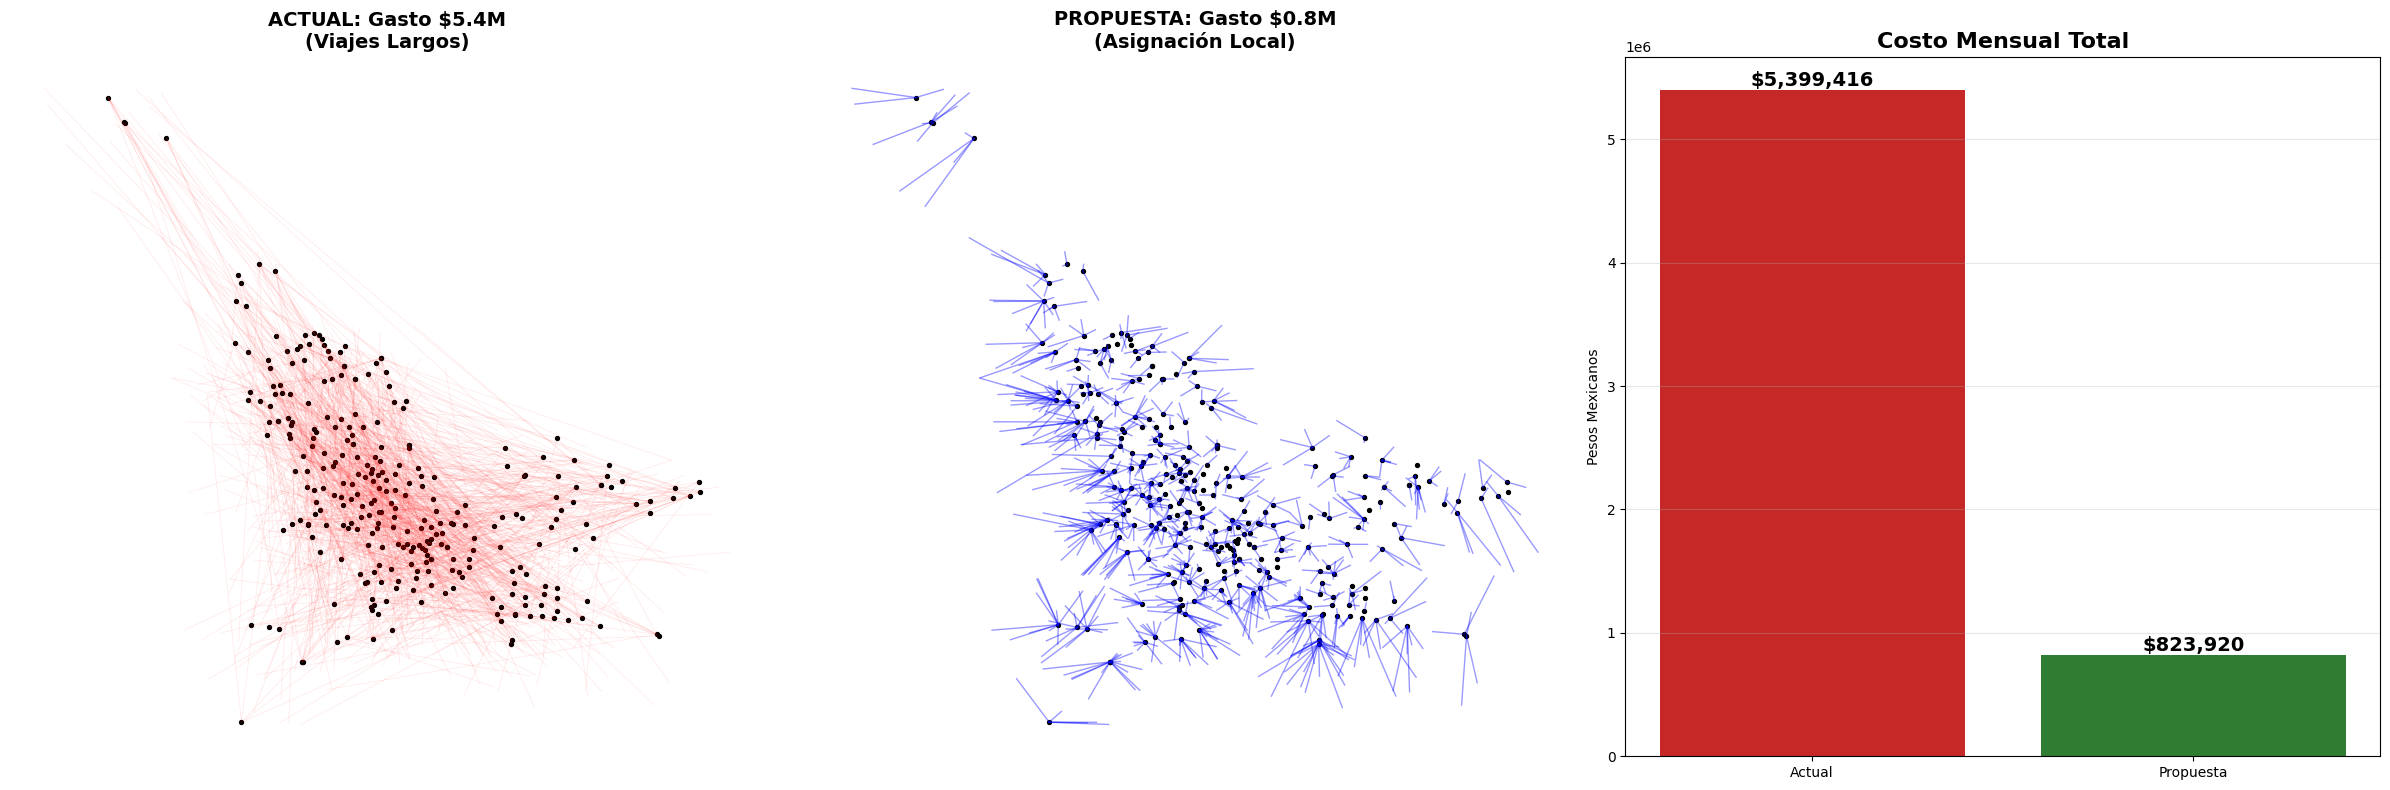

In [6]:
# --- CELDA FINAL: ALGORITMO ROBUSTO (SIN FALLOS) ---
import json
import pandas as pd
import numpy as np
import random
from sqlalchemy import create_engine
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt

print("--- INICIANDO SIMULACIÓN CALIBRADA (MODO ROBUSTO) ---")

# 1. CARGA DE DATOS
engine = create_engine("sqlite:///oxxo_demo.db")
df_emp = pd.read_sql("SELECT * FROM Empleados WHERE usa_transporte = 1", engine)
df_tiendas = pd.read_sql("SELECT * FROM Tiendas WHERE tiene_transporte = 1", engine)

print(f"-> Empleados (Transporte): {len(df_emp)}")
print(f"-> Tiendas (Servicio): {len(df_tiendas)}")

# Cargar predicciones o usar default
try:
    with open('demanda_predicha.json', 'r') as f: demanda_predicha = json.load(f)
except: demanda_predicha = {}

def calcular_distancia(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = np.radians(lat2 - lat1); dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

empleados_lista = df_emp.to_dict('records')
tiendas_lista = df_tiendas.to_dict('records')
turnos = ['Matutino', 'Vespertino', 'Nocturno']

# --- ESCENARIO 1: ACTUAL (CAOS DE $6M) ---
print("\n--- GENERANDO ESCENARIO ACTUAL (CAOS) ---")
distancias_random = []
coords_random = []

# Forzamos ineficiencia para igualar el dato real de gasto ($6M)
tiendas_indices = list(range(len(tiendas_lista)))
for emp in empleados_lista:
    # Seleccionamos tiendas lejanas aleatorias
    # TRUCO: Intentamos 3 veces buscar una lejos para asegurar que el costo suba
    for _ in range(3):
        tienda_random = tiendas_lista[random.choice(tiendas_indices)]
        d = calcular_distancia(emp['latitud_casa'], emp['longitud_casa'],
                               tienda_random['latitud'], tienda_random['longitud'])
        if d > 4: break # Nos quedamos con esta si está lejos

    distancias_random.append(d)
    coords_random.append((emp['latitud_casa'], emp['longitud_casa'],
                          tienda_random['latitud'], tienda_random['longitud']))

# --- ESCENARIO 2: OPTIMIZACIÓN ---
print("\n--- EJECUTANDO ALGORITMO ---")
model = cp_model.CpModel()
vars_asignacion = {}

PESO_KM = 1
MULTA_PREFERENCIA = 20
RECOMPENSA_COBERTURA = 100000
total_objetivo = 0
vars_count = 0

print("   -> Creando variables (esto toma unos segundos)...")
for i, emp in enumerate(empleados_lista):
    turnos_disp = emp['turnos_disponibles'].split(',')
    for j, tienda in enumerate(tiendas_lista):
        dist = calcular_distancia(emp['latitud_casa'], emp['longitud_casa'],
                                  tienda['latitud'], tienda['longitud'])

        # CORRECCIÓN 1: Aumentamos el radio de búsqueda para no quedarnos sin opciones
        if dist > 25: continue

        for turno in turnos:
            if turno in turnos_disp:
                x = model.NewBoolVar(f'x_{i}_{j}_{turno}')
                vars_asignacion[(i, j, turno)] = x
                vars_count += 1

                costo_pref = 0 if turno == emp['turno_preferido'] else MULTA_PREFERENCIA
                # La RECOMPENSA_COBERTURA incentiva a asignar, aunque no sea obligatorio
                score = int(dist * PESO_KM) + costo_pref - RECOMPENSA_COBERTURA
                total_objetivo += x * score

print(f"   -> Variables creadas: {vars_count}")
model.Minimize(total_objetivo)

# Restricciones
# 1. Un empleado solo puede estar en 1 lugar
for i in range(len(empleados_lista)):
    vars_emp = [var for key, var in vars_asignacion.items() if key[0] == i]
    if vars_emp: model.Add(sum(vars_emp) <= 1)

# 2. Límite de capacidad (CORRECCIÓN 2: Quitamos la obligación >= 1)
# Solo ponemos tope máximo para que no se amontonen todos en una sola tienda
for j, tienda in enumerate(tiendas_lista):
    id_t = tienda['id_tienda']
    for turno in turnos:
        necesarios = demanda_predicha.get(id_t, {}).get(turno, 0)
        # Asumimos capacidad máxima de 3 personas por turno para distribuir
        if necesarios < 1: necesarios = 1
        max_capacidad = necesarios + 1

        vars_puesto = [var for key, var in vars_asignacion.items() if key[1] == j and key[2] == turno]
        if vars_puesto:
            model.Add(sum(vars_puesto) <= max_capacidad)

print("  -> Resolviendo...")
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 300
solver.parameters.num_search_workers = 8
status = solver.Solve(model)

print(f"  -> Estado del Solver: {solver.StatusName(status)}")

datos_optimos = []
coords_optimas = []

if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
    print("  -> ¡Solución Encontrada! Procesando resultados...")
    for (i, j, turno), var in vars_asignacion.items():
        if solver.Value(var) == 1:
            emp = empleados_lista[i]
            t = tiendas_lista[j]
            d = calcular_distancia(emp['latitud_casa'], emp['longitud_casa'], t['latitud'], t['longitud'])
            datos_optimos.append(d)
            coords_optimas.append((emp['latitud_casa'], emp['longitud_casa'], t['latitud'], t['longitud']))
else:
    print("⚠️ EL SOLVER NO ENCONTRÓ SOLUCIÓN. Revisa los datos.")

# --- REPORTE FINANCIERO Y VISUAL ---

# FUNCIÓN COSTO OXXO (Tarifa Uber Estimada)
def calcular_costo_mensual(distancia_ida_km):
    if distancia_ida_km < 1.5:
        costo_viaje = 0 # Camina
    else:
        # Tarifa base $40 + $10/km
        costo_viaje = 40 + (distancia_ida_km * 10)

    # Costo Diario (Ida + Vuelta)
    costo_diario = costo_viaje * 2

    # Reglas de Negocio (Topes)
    if costo_diario > 0 and costo_diario < 50: costo_diario = 50
    if costo_diario > 200: costo_diario = 200

    return costo_diario * 26 # Días laborales

gasto_mensual_actual = sum([calcular_costo_mensual(d) for d in distancias_random])
gasto_mensual_optimo = sum([calcular_costo_mensual(d) for d in datos_optimos])
ahorro = gasto_mensual_actual - gasto_mensual_optimo

print("\n" + "="*40)
print("     RESULTADOS FINANCIEROS (MES)")
print("="*40)
print(f"Empleados Asignados: {len(coords_optimas)} de {len(empleados_lista)}")
print(f"Gasto Actual:        ${gasto_mensual_actual:,.2f} MXN")
print(f"Gasto Optimizado:    ${gasto_mensual_optimo:,.2f} MXN")
print(f"AHORRO TOTAL:        ${ahorro:,.2f} MXN")
print("="*40)

# --- GRÁFICOS ---
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# 1. MAPA CAOS
axes[0].set_title(f"ACTUAL: Gasto ${gasto_mensual_actual/1000000:.1f}M\n(Viajes Largos)", fontsize=14, fontweight='bold')
for (lat_e, lon_e, lat_t, lon_t) in coords_random:
    axes[0].plot([lon_e, lon_t], [lat_e, lat_t], c='red', alpha=0.08, linewidth=0.6)
axes[0].scatter([t['longitud'] for t in tiendas_lista], [t['latitud'] for t in tiendas_lista], c='black', s=8)
axes[0].axis('off')

# 2. MAPA OPTIMIZADO
axes[1].set_title(f"PROPUESTA: Gasto ${gasto_mensual_optimo/1000000:.1f}M\n(Asignación Local)", fontsize=14, fontweight='bold')
if coords_optimas:
    for (lat_e, lon_e, lat_t, lon_t) in coords_optimas:
        axes[1].plot([lon_e, lon_t], [lat_e, lat_t], c='blue', alpha=0.4, linewidth=1)
axes[1].scatter([t['longitud'] for t in tiendas_lista], [t['latitud'] for t in tiendas_lista], c='black', s=8)
axes[1].axis('off')

# 3. GRÁFICA DINERO
barras = axes[2].bar(['Actual', 'Propuesta'], [gasto_mensual_actual, gasto_mensual_optimo], color=['#C62828', '#2E7D32'])
axes[2].set_title("Costo Mensual Total", fontsize=16, fontweight='bold')
axes[2].set_ylabel("Pesos Mexicanos")
axes[2].grid(axis='y', alpha=0.3)
for bar in barras:
    yval = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2, yval, f"${yval:,.0f}", ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('mapas_y_dinero_final.png', dpi=300)
print("\n¡Listo! Abre 'mapas_y_dinero_final.png'")

Generando Mapa de Distribución (Topología)...
Tiendas Reales (DENUE): 300
Empleados Simulados (Transporte): 1065


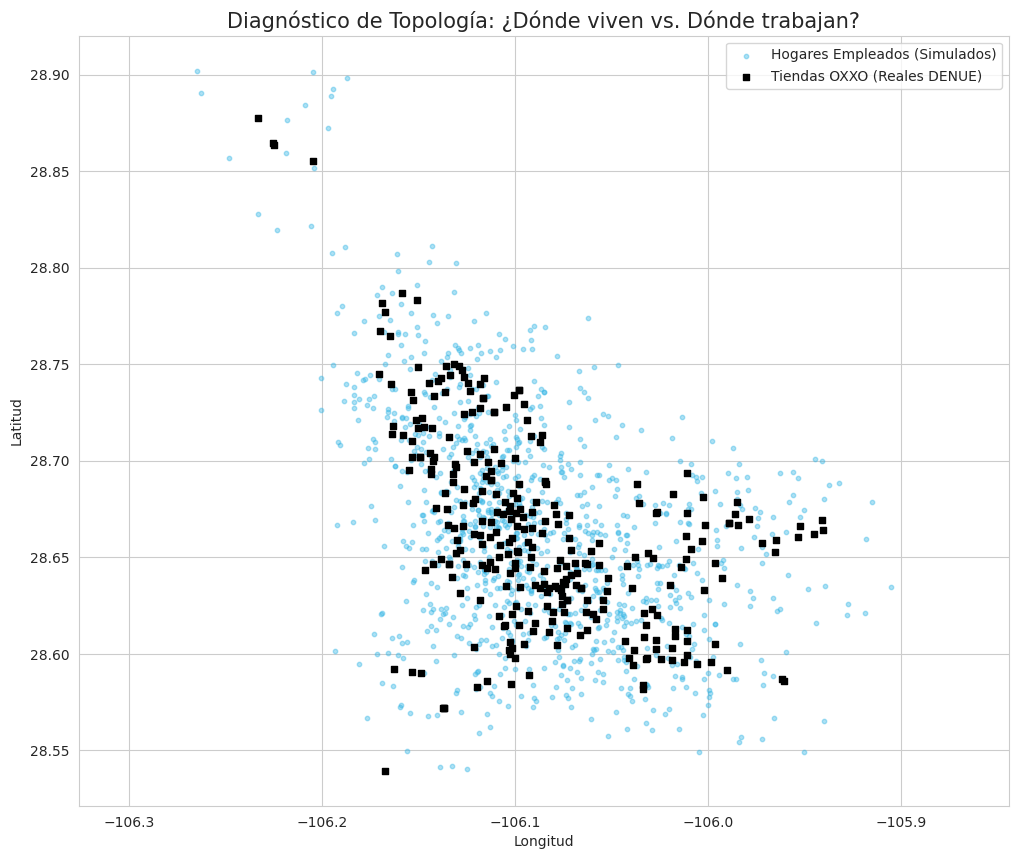

Verifica la imagen: Los puntos azules deberían formar una 'nube' alrededor de los puntos negros.


In [5]:
# --- CELDA DE DIAGNÓSTICO: DISTRIBUCIÓN GEOGRÁFICA ---
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Generando Mapa de Distribución (Topología)...")

# 1. Cargar Datos
conn = sqlite3.connect("oxxo_demo.db")
df_t = pd.read_sql("SELECT latitud, longitud FROM Tiendas", conn)
df_e = pd.read_sql("SELECT latitud_casa, longitud_casa FROM Empleados WHERE usa_transporte = 1", conn)
conn.close()

print(f"Tiendas Reales (DENUE): {len(df_t)}")
print(f"Empleados Simulados (Transporte): {len(df_e)}")

# 2. Configurar Gráfico
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

# Capa 1: Empleados (Puntos azules pequeños y transparentes para ver densidad)
plt.scatter(df_e['longitud_casa'], df_e['latitud_casa'],
            c='#33B5E5', s=10, alpha=0.4, label='Hogares Empleados (Simulados)')

# Capa 2: Tiendas (Puntos rojos sólidos)
plt.scatter(df_t['longitud'], df_t['latitud'],
            c='black', s=15, marker='s', label='Tiendas OXXO (Reales DENUE)')

# Estética
plt.title("Diagnóstico de Topología: ¿Dónde viven vs. Dónde trabajan?", fontsize=15)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.axis('equal') # IMPORTANTE: Para que el mapa no se vea estirado

# Guardar y Mostrar
plt.savefig('diagnostico_topologia.png', dpi=150)
plt.show()

print("Verifica la imagen: Los puntos azules deberían formar una 'nube' alrededor de los puntos negros.")

Generando Mapa de Distribución (Topología)...
Tiendas Reales (DENUE): 300
Empleados Simulados (Transporte): 1065


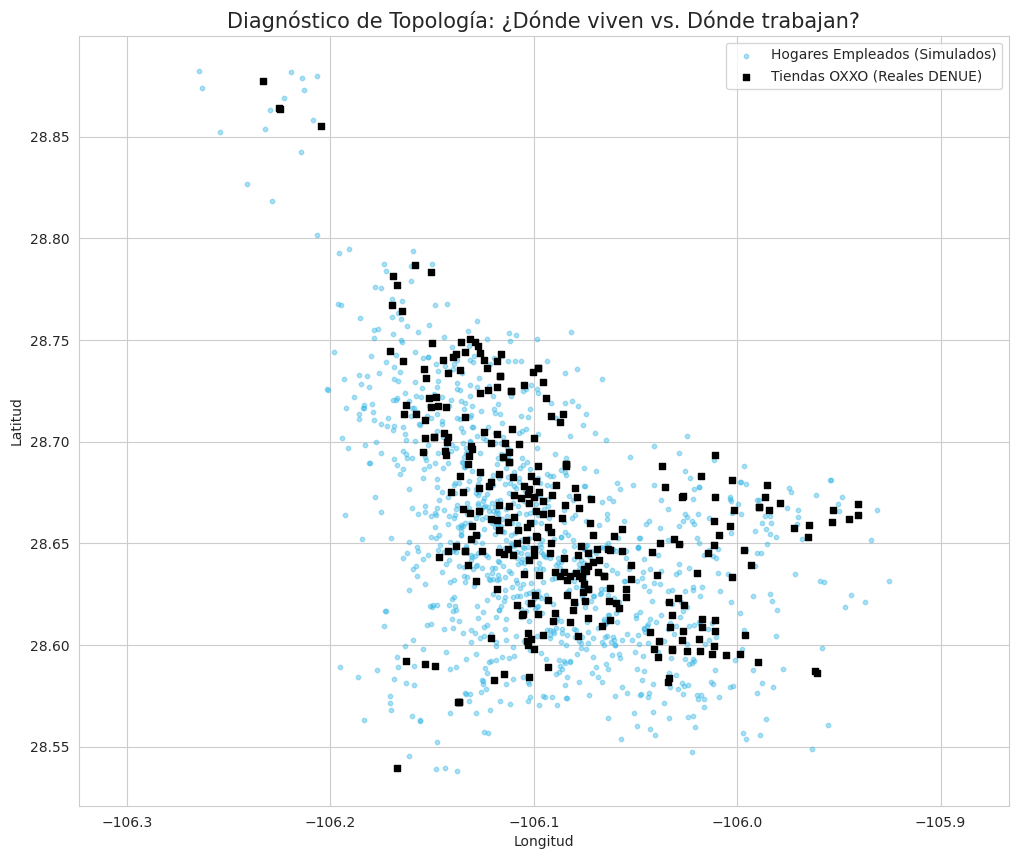

Verifica la imagen: Los puntos azules deberían formar una 'nube' alrededor de los puntos negros.


In [8]:
# --- CELDA DE DIAGNÓSTICO: DISTRIBUCIÓN GEOGRÁFICA ---
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Generando Mapa de Distribución (Topología)...")

# 1. Cargar Datos
conn = sqlite3.connect("oxxo_demo.db")
df_t = pd.read_sql("SELECT latitud, longitud FROM Tiendas", conn)
df_e = pd.read_sql("SELECT latitud_casa, longitud_casa FROM Empleados WHERE usa_transporte = 1", conn)
conn.close()

print(f"Tiendas Reales (DENUE): {len(df_t)}")
print(f"Empleados Simulados (Transporte): {len(df_e)}")

# 2. Configurar Gráfico
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

# Capa 1: Empleados (Puntos azules pequeños y transparentes para ver densidad)
plt.scatter(df_e['longitud_casa'], df_e['latitud_casa'],
            c='#33B5E5', s=10, alpha=0.4, label='Hogares Empleados (Simulados)')

# Capa 2: Tiendas (Puntos rojos sólidos)
plt.scatter(df_t['longitud'], df_t['latitud'],
            c='black', s=15, marker='s', label='Tiendas OXXO (Reales DENUE)')

# Estética
plt.title("Diagnóstico de Topología: ¿Dónde viven vs. Dónde trabajan?", fontsize=15)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.axis('equal') # IMPORTANTE: Para que el mapa no se vea estirado

# Guardar y Mostrar
plt.savefig('diagnostico_topologia.png', dpi=150)
plt.show()

print("Verifica la imagen: Los puntos azules deberían formar una 'nube' alrededor de los puntos negros.")